In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# PRELIM DATA PROCESSING

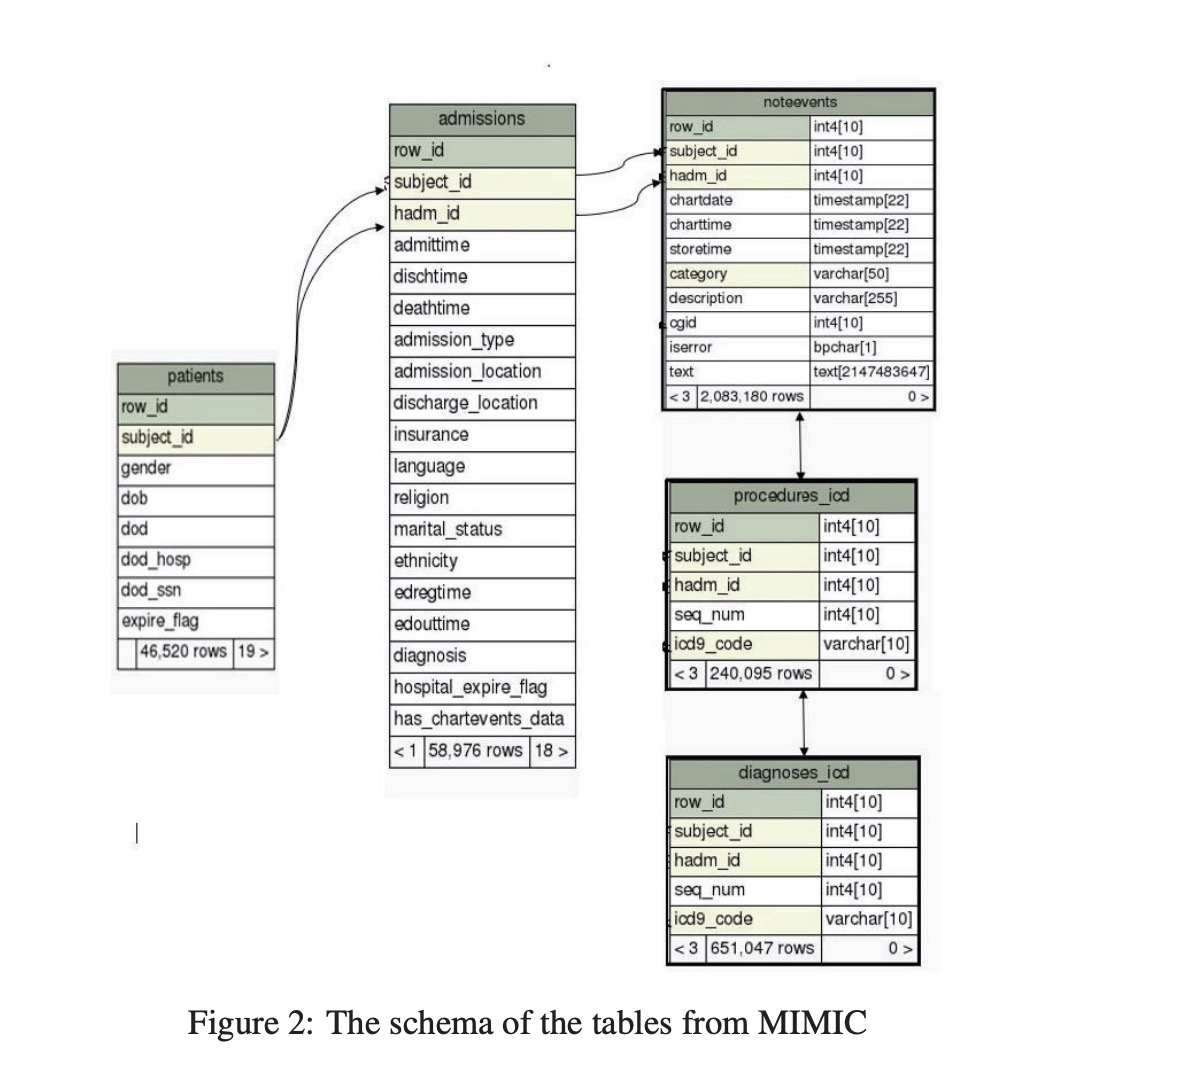

The above [graph](https://arxiv.org/pdf/1912.12397.pdf) enables us to see the relations and shared variables among individual datastes. The idea is to find useful dataset to combine for our later analysis. 


Refering to the [user guide](https://mimic.physionet.org/archive/mimic-ii-guide.pdf), MIMIC datasets can be roughly divided into two kinds: instructional and records. The instructional works like legend, linking the code of diagnosis, drugs, etc to perfessional nouns. Records are what we care about here. They record patients' data and usually begins with different ids, such as `row_id` and `subject_id`. The records can be divided further: static record, meaning each row is for one patient; time series record, meaning the records corresponds to a single patient in different time interval (like laboratory tests for different days).


We are acknowledged that from the website, several deidentification has been done to protect patients' identitides. However, we believe there still exist privavy issue when linking these datasets. We admit that it is possibly an inenvitable drawback of medical dataset, here, our first step is to determine to what extent these privacy issues are. Based on that, we have several criteria of choosing our analyzable datasets. First, the dataset must contains enough personal or demographic information linking to the individual patient. Then, these information cannot be too specific, for example, the prescription text or notes the doctor made before or in the process of ICU admission (although de-identified). Our first criterion helps us omit dataset such as `SERVICES` and `TRANSFERS`. Our second criterion excludes the usage of `NOTEEVENTS`, and any time series related `LABEVENTS`, or `MICROBIOLOGYEVENTS`.

In the end, we will combine `ADMISSIONS`, `PATIENTS`, and `ICUSTAYS`. As for linkage, we will use unique `subject_id` to merge these datasets. 

In [2]:
## import data set
# in local 
admissions = pd.read_csv('./data/ADMISSIONS.csv')
patients = pd.read_csv('./data/PATIENTS.csv')
icu =  pd.read_csv('./data/ICUSTAYS.csv')

# on colab

#from google.colab import files
#uploaded = files.upload()

#admissions = pd.read_csv('ADMISSIONS.csv')
#patients = pd.read_csv('PATIENTS.csv')
#icu =  pd.read_csv('ICUSTAYS.csv')


In [3]:
admissions = admissions.drop(columns=['ROW_ID','HADM_ID','HAS_CHARTEVENTS_DATA','HOSPITAL_EXPIRE_FLAG','EDREGTIME', 'EDOUTTIME'])

In [4]:
admissions

,SUBJECT_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS
0,22,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE
1,23,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
2,23,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS
3,24,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION
4,25,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,98800,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,TRAUMA
58972,98802,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,SAH
58973,98805,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,RENAL CANCER/SDA
58974,98813,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,S/P FALL


The `ADMISSIONS` dataset contains 58976 entries. In `admissions`, we have basically demographic features. More importantly, we know the patient is dead or not by `DEATHTIME`.

In [5]:
patients = patients.drop(columns=['ROW_ID','DOD_SSN','EXPIRE_FLAG'])

In [6]:
patients

,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP
0,249,F,2075-03-13 00:00:00,NaN,NaN
1,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00
2,251,M,2090-03-15 00:00:00,NaN,NaN
3,252,M,2078-03-06 00:00:00,NaN,NaN
4,253,F,2089-11-26 00:00:00,NaN,NaN
...,...,...,...,...,...
46515,44089,M,2026-05-25 00:00:00,NaN,NaN
46516,44115,F,2124-07-27 00:00:00,NaN,NaN
46517,44123,F,2049-11-26 00:00:00,2135-01-12 00:00:00,2135-01-12 00:00:00
46518,44126,F,2076-07-25 00:00:00,NaN,NaN


The `PATIENTS` dataset contains 46520 entries. Here, we will have `gender` and `DOB` `DOD` `DOD_HOSP` (date of birth and date of death in hospital) , we can get the age information. We deplete columns with repetitive death information. 

In [7]:
icu = icu.drop(columns=['ROW_ID','HADM_ID','ICUSTAY_ID','DBSOURCE'])

In [8]:
icu

,SUBJECT_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,268,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,269,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,270,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,271,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,272,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202
...,...,...,...,...,...,...,...,...
61527,94944,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.1894
61528,94950,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,2.4942
61529,94953,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,0.9259
61530,94954,CSRU,CSRU,15,15,2183-03-25 09:53:10,2183-03-27 17:55:03,2.3346


The `ICUSTAYS` dataset contains 61532 entries. Here, `los` is very useful for us, because it has recorded the length of stay for patients in ICU. Also, the identification of wardid is important. 

In [9]:
temp = pd.merge(admissions,patients, left_on='SUBJECT_ID', right_on='SUBJECT_ID')

In [10]:
df = pd.merge(temp,icu,left_on='SUBJECT_ID', right_on='SUBJECT_ID')

In [11]:
df

,SUBJECT_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,DOB,DOD,DOD_HOSP,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,22,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,2131-05-07 00:00:00,NaN,NaN,MICU,MICU,52,52,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438
1,23,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,...,2082-07-17 00:00:00,NaN,NaN,CSRU,CSRU,14,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641
2,23,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,...,2082-07-17 00:00:00,NaN,NaN,SICU,SICU,57,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862
3,23,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,...,2082-07-17 00:00:00,NaN,NaN,CSRU,CSRU,14,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641
4,23,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,...,2082-07-17 00:00:00,NaN,NaN,SICU,SICU,57,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116421,98794,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,...,2049-07-29 00:00:00,NaN,NaN,CSRU,CSRU,15,15,2127-11-07 10:02:54,2127-11-09 16:58:46,2.2888
116422,98797,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,...,2044-12-27 00:00:00,2132-12-25 00:00:00,2132-12-25 00:00:00,MICU,MICU,50,50,2132-12-24 20:08:16,2132-12-26 01:51:14,1.2382
116423,98800,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,...,2111-11-05 00:00:00,NaN,NaN,TSICU,TSICU,14,14,2131-03-30 21:14:14,2131-03-31 18:18:14,0.8778
116424,98802,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,...,2067-09-21 00:00:00,2151-03-06 00:00:00,2151-03-06 00:00:00,MICU,MICU,50,50,2151-03-05 20:01:18,2151-03-06 10:54:24,0.6202


In [12]:
# get y variables:
df['MORTALITY'] = np.where(df['DOD'].isnull(),0,1 ) 

In [13]:
df['MORTALITY']

0         0
1         0
2         0
3         0
4         0
         ..
116421    0
116422    1
116423    0
116424    1
116425    0
Name: MORTALITY, Length: 116426, dtype: int64

Note, because each patient may be admitted into ICU for several times, the resultant dataset size is almost doubled. We can proceed in two ways: keep the whole vs. keep the unique (random selection)

Till here, it is enough for privavy analysis. The final step is to convert datetime object, if needed.

In [14]:
df.columns

Index(['SUBJECT_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'GENDER', 'DOB',
       'DOD', 'DOD_HOSP', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID',
       'LAST_WARDID', 'INTIME', 'OUTTIME', 'LOS', 'MORTALITY'],
      dtype='object')

In [15]:
### if needed, to convert all date time to datetime object
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'], errors='ignore')
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'], errors='ignore')
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'], errors='ignore')
df['DOB'] = pd.to_datetime(df['DOB'], errors='ignore')
df['DOD'] = pd.to_datetime(df['DOD'], errors='ignore')
df['DOD_HOSP'] = pd.to_datetime(df['DOD_HOSP'], errors='ignore')
df['INTIME'] = pd.to_datetime(df['INTIME'], errors='ignore')
df['OUTTIME'] = pd.to_datetime(df['OUTTIME'], errors='ignore')

import warnings
warnings.filterwarnings("ignore")

In [16]:
### output

df.to_csv('./prelim.csv')
#check = pd.read_csv('./data/prelim.csv').drop(columns = 'Unnamed:0')

# FURTHER DATA PROCESSING FOR MODELING

The first issue arises here is the deplication of patient's records. It will greatly help with privatization, but how about we remove the duplicates?

In [17]:
# ??? Brutal force to remove deplicates
df1 = df.drop_duplicates(subset = ["SUBJECT_ID"])

In [35]:
### output 2
df1.to_csv('./prelim_no_duplicate.csv')
#check = pd.read_csv('./data/prelim.csv').drop(columns = 'Unnamed:0')

In [34]:
df.shape

(116426, 26)

After choosing which to proceed, we add variables for analysis. 

### EDA

In [36]:
df1['AGE']= df1['DOD'].dt.year-df1['DOB'].dt.year

In [58]:
f_age = df1[df1['GENDER' ]== 'F']['AGE'].to_numpy()
m_age = df1[df1['GENDER' ]== 'M']['AGE'].to_numpy()
age_df = [f_age, m_age]

[array([nan, nan, nan, ..., 81., nan, 84.]),
 array([nan, nan, nan, ..., nan, 88., nan])]

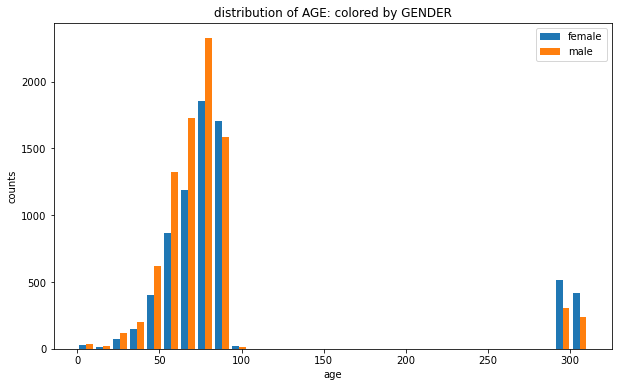

In [71]:
n_bins=30
plt.figure(figsize=(10,6))
plt.hist(age_df, n_bins, histtype='bar', label = ['female','male'])
plt.legend()
plt.title('distribution of AGE: colored by GENDER')
plt.ylabel('counts')
plt.xlabel('age')
plt.show()

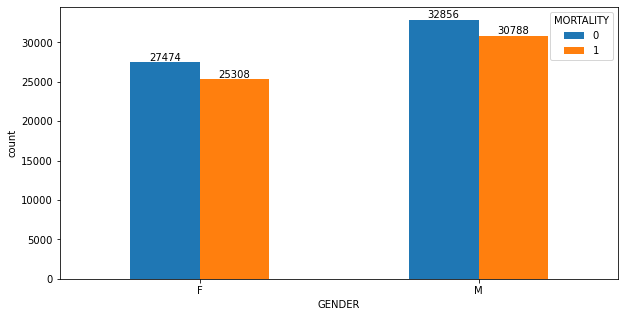

In [87]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
df.groupby(['GENDER','MORTALITY']).size().unstack(fill_value=0).plot(kind='bar',ax=ax,rot=0)
plt.ylabel('count')
for p in ax.patches:
    ax.annotate(np.round(p.get_height()),(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='bottom')
plt.show()

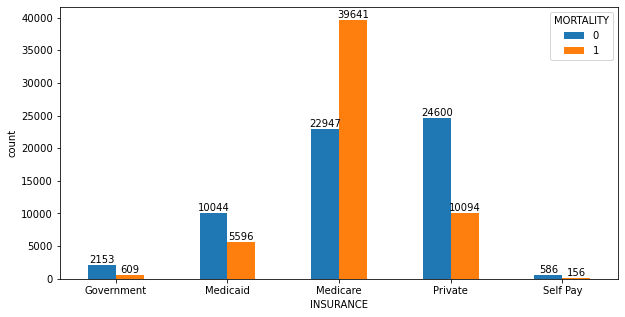

In [90]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
df.groupby(['INSURANCE','MORTALITY']).size().unstack(fill_value=0).plot(kind='bar',ax=ax,rot=0)
plt.ylabel('count')
for p in ax.patches:
    ax.annotate(np.round(p.get_height()),(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='bottom')
plt.show()

In [91]:
df['OLD'] = np.where(df['AGE']>=60,1,0 ) 

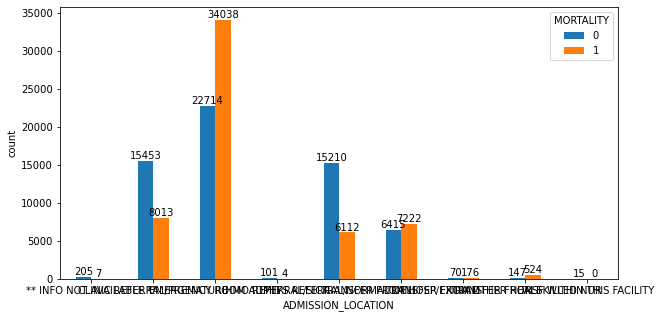

In [95]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
df.groupby(['ADMISSION_LOCATION','MORTALITY']).size().unstack(fill_value=0).plot(kind='bar',ax=ax,rot=0)
plt.ylabel('count')
for p in ax.patches:
    ax.annotate(np.round(p.get_height()),(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='bottom')
plt.show()

Text(0.5, 0, 'age')

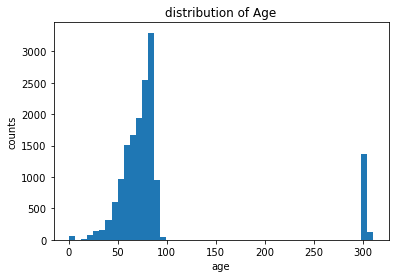

In [88]:
plt.hist(df1.AGE,bins = 50)
plt.title("distribution of Age")
plt.ylabel('counts')
plt.xlabel('age')

Text(0.5, 0, 'Gender')

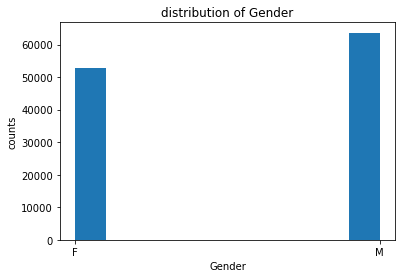

In [89]:
plt.hist(df.GENDER)
plt.title("distribution of Gender")
plt.ylabel('counts')
plt.xlabel('Gender')

In [76]:
df.ETHNICITY.value_counts()

WHITE                                                       76855
BLACK/AFRICAN AMERICAN                                      20304
UNKNOWN/NOT SPECIFIED                                        5683
HISPANIC OR LATINO                                           3138
OTHER                                                        2518
ASIAN                                                        2073
UNABLE TO OBTAIN                                              946
HISPANIC/LATINO - PUERTO RICAN                                818
PATIENT DECLINED TO ANSWER                                    747
ASIAN - CHINESE                                               409
WHITE - RUSSIAN                                               352
ASIAN - ASIAN INDIAN                                          336
BLACK/CAPE VERDEAN                                            323
PORTUGUESE                                                    226
MULTI RACE ETHNICITY                                          208
BLACK/HAIT

In [82]:
df.INSURANCE.value_counts()

Medicare      62588
Private       34694
Medicaid      15640
Government     2762
Self Pay        742
Name: INSURANCE, dtype: int64

Text(0.5, 0, 'Lengt of Stay in ICU')

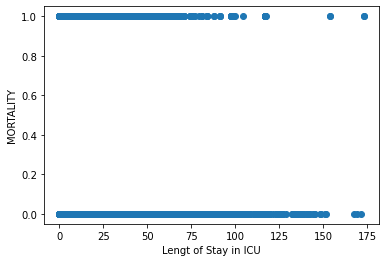

In [98]:
plt.scatter(df.LOS,df.MORTALITY)
plt.ylabel('MORTALITY')
plt.xlabel('Lengt of Stay in ICU')

In [119]:
df_sim = df[(df['ETHNICITY'] =='WHITE') | (df['ETHNICITY'] =='BLACK/AFRICAN AMERICAN')
           | (df['ETHNICITY'] =='HISPANIC OR LATINO')
           | (df['ETHNICITY'] =='ASIAN')]

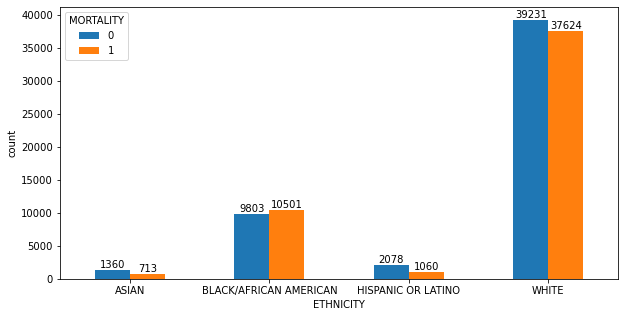

In [120]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
df_sim.groupby(['ETHNICITY','MORTALITY']).size().unstack(fill_value=0).plot(kind='bar',ax=ax,rot=0)
plt.ylabel('count')
for p in ax.patches:
    ax.annotate(np.round(p.get_height()),(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='bottom')
plt.show()

# APPENDIX 




## variable name

`SUBJECT_ID`: an integer number identifying a particular patient. This can be thought of as a substitute for a unique medical record number. In the flat file data posted on PhysioNet, the number representing the Subject ID is left padded with zeros to five digits and preceded by the letter s. In the relational database, the Subject ID has no preceding
letter or leading zeros.

`ADMITTIME`: time stamp admitted into the hospital

`DISCHTIME`: time stamp discharged out of the hospital

`DEATHTIME`: time stamp of death

 `ADMISSION_TYPE`: admission type

`ADMISSION_LOCATION`: admission room location

 `DISCHARGE_LOCATION`: discharge location

 `INSURANCE`: insurance type

 `LANGUAGE` : used language

`RELIGION`: religion

`MARITAL_STATUS`: marital status

 `ETHNICITY`: ethinicity

  `DIAGNOSIS'`: diagonosis

  `MORTALITY`:  binary, has value 1 if deathtime is not NaN

`GENDER` : gender

`DOB` : time stamp, date of birth

`DOD` : time stamp, date of death (maybe unknown to hospital)

`DOD_HOSP`: time stamp, date of death in the hospital

 `DBSOURCE'`: data base source, can ignore

 
 `FIRST_CAREUNIT`: first care unit type stayed

`LAST_CAREUNIT`: last care unit type stayed

 `FIRST_WARDID`: first wardid had, number

  `LAST_WARDID`: last wardid had, number

   `INTIME'`: time stamp into the ICU

   `OUTTIME`: time stamp out of the ICU

  `LOS`: length stayed in the ICU, in day